In [13]:
import torch
from architecture import resnet50
import imageio
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# load classes names
with open('sets/classes.txt', 'r') as f:
    classes = [l.strip() for l in f.readlines()]
print('Loaded {} classes:'.format(len(classes)))
print('\n'.join(classes))

Loaded 10 classes:
11H(ANTONY OF PADUA)
11H(JOHN THE BAPTIST)
11H(PAUL)
11H(FRANCIS)
11HH(MARY MAGDALENE)
11H(JEROME)
11H(DOMINIC)
11F(MARY)
11H(PETER)
11H(SEBASTIAN)


In [15]:
from torch.nn import ReLU

# initialize model
num_classes = 10
model = resnet50.Grad(num_classes) # Own Modification
'''
for module in model.modules():
            if isinstance(module, ReLU):
                print('hi')
'''

"\nfor module in model.modules():\n            if isinstance(module, ReLU):\n                print('hi')\n"

In [16]:
# load weights
weights_path = 'model/res50.pth'
model.load_state_dict(torch.load(weights_path), strict=True)
print('Model loaded')

Model loaded


In [17]:
# set model to be run on GPU
#model.cuda()
# set model to run on eval mode
model.eval()

In [18]:
def normalize_img(img):
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    imgarr = np.asarray(img) / 255
    
    proc_img = np.empty_like(imgarr, np.float32)
    proc_img[..., 0] = (imgarr[..., 0] - mean[0]) / std[0]
    proc_img[..., 1] = (imgarr[..., 1] - mean[1]) / std[1]
    proc_img[..., 2] = (imgarr[..., 2] - mean[2]) / std[2]

    return proc_img

def HWC_to_CHW(img):
    return np.transpose(img, (2, 0, 1))

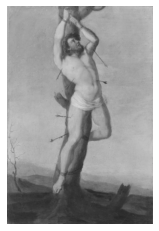

In [19]:
# load img
img_path = 'test-data/Q18599229.jpg'
img = np.asarray(imageio.imread(img_path))
# show img
plt.imshow(img)
plt.axis('off')
plt.show()

In [20]:
# normalize img based on imagenet std and mean
img = normalize_img(img)
# transpose channel to have (3, H, W)
img = HWC_to_CHW(img)
# add batch to dimensions
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 3, 898, 600)


In [21]:
# numpy to pytorch tensor
img = torch.from_numpy(img)
# load image on gpu
#img = img.cuda()
print(img)

# Looks like the other method give 2 different tensors.
'''
from PIL import Image
img2 = Image.open(img_path).convert('RGB')

input = transform(img2)
input.unsqueeze_(0)
input.requires_grad = True

input = input.cuda() #Extra line

print(input)
'''

tensor([[[[ 0.9132,  0.8961,  0.9132,  ...,  0.1597,  0.1426,  0.0741],
          [ 0.8961,  0.9132,  0.9474,  ...,  1.0502,  1.0159,  0.9303],
          [ 0.9132,  0.9474,  0.9988,  ...,  1.1187,  1.0502,  0.9474],
          ...,
          [-0.1657, -0.2513, -0.3541,  ..., -1.0219, -0.9534, -0.6965],
          [-0.0458, -0.0972, -0.1657,  ..., -1.0733, -0.9020, -0.6794],
          [-0.0458, -0.0972, -0.1657,  ..., -1.0562, -0.9020, -0.6794]],

         [[ 1.0630,  1.0455,  1.0630,  ...,  0.2927,  0.2752,  0.2052],
          [ 1.0455,  1.0630,  1.0980,  ...,  1.2031,  1.1681,  1.0805],
          [ 1.0630,  1.0980,  1.1506,  ...,  1.2731,  1.2031,  1.0980],
          ...,
          [-0.0399, -0.1275, -0.2325,  ..., -0.9153, -0.8452, -0.5826],
          [ 0.0826,  0.0301, -0.0399,  ..., -0.9678, -0.7927, -0.5651],
          [ 0.0826,  0.0301, -0.0399,  ..., -0.9503, -0.7927, -0.5651]],

         [[ 1.2805,  1.2631,  1.2805,  ...,  0.5136,  0.4962,  0.4265],
          [ 1.2631,  1.2805,  

"\nfrom PIL import Image\nimg2 = Image.open(img_path).convert('RGB')\n\ninput = transform(img2)\ninput.unsqueeze_(0)\ninput.requires_grad = True\n\ninput = input.cuda() #Extra line\n\nprint(input)\n"

In [22]:
'''
# run model on img
output = model(img)
print(output)
# get probabilities from sigmoid
preds = torch.sigmoid(output[0])
probs = preds.data.cpu().numpy()
print(probs)
'''

'\n# run model on img\noutput = model(img)\nprint(output)\n# get probabilities from sigmoid\npreds = torch.sigmoid(output[0])\nprobs = preds.data.cpu().numpy()\nprint(probs)\n'

In [23]:
for c, p in list(zip(classes, probs)):
    print('{} - {:.4f}'.format(c, p))

NameError: name 'probs' is not defined

In [27]:
# Code from https://github.com/hs2k/pytorch-smoothgrad

from torch.autograd import Variable

class VanillaGrad(object):

    def __init__(self, pretrained_model, cuda=False):
        self.pretrained_model = pretrained_model
        #self.features = pretrained_model.features
        self.cuda = cuda
        #self.pretrained_model.eval()

    def __call__(self, x, index=None):
 
        output = self.pretrained_model(x)
        
        if index is None:
            index = np.argmax(output.data.cpu().numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        if self.cuda:
            one_hot = Variable(torch.from_numpy(one_hot).cuda(), requires_grad=True)
            #one_hot = torch.from_numpy(one_hot).cuda()
            #one_hot.requires_grad = True
        else:
            one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
        one_hot = torch.sum(one_hot * output)

        one_hot.backward(retain_graph=True)

        grad = x.grad.data.cpu().numpy()
        grad = grad[0, :, :, :]

        return grad
 
 
class SmoothGrad(VanillaGrad):

    def __init__(self, pretrained_model, cuda=False, stdev_spread=0.15,
                 n_samples=25, magnitude=True):
        super(SmoothGrad, self).__init__(pretrained_model, cuda)
        """
        self.pretrained_model = pretrained_model
        self.features = pretrained_model.features
        self.cuda = cuda
        self.pretrained_model.eval()
        """
        self.stdev_spread = stdev_spread
        self.n_samples = n_samples
        self.magnitutde = magnitude

    def __call__(self, x, index=None):
        x = x.data.cpu().numpy()
        stdev = self.stdev_spread * (np.max(x) - np.min(x))
        total_gradients = np.zeros_like(x)
        for i in range(self.n_samples):
            noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
            x_plus_noise = x + noise
            if self.cuda:
                x_plus_noise = Variable(torch.from_numpy(x_plus_noise).cuda(), requires_grad=True)
            else:
                x_plus_noise = Variable(torch.from_numpy(x_plus_noise), requires_grad=True)
            output = self.pretrained_model(x_plus_noise)

            if index is None:
                index = np.argmax(output.data.cpu().numpy())

            one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
            one_hot[0][index] = 1
            if self.cuda:
                one_hot = Variable(torch.from_numpy(one_hot).cuda(), requires_grad=True)
            else:
                one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
            one_hot = torch.sum(one_hot * output)

            if x_plus_noise.grad is not None:
                x_plus_noise.grad.data.zero_()
            one_hot.backward(retain_graph=True)

            grad = x_plus_noise.grad.data.cpu().numpy()

            if self.magnitutde:
                total_gradients += (grad * grad)
            else:
                total_gradients += grad
            #if self.visdom:

        avg_gradients = total_gradients[0, :, :, :] / self.n_samples

        return avg_gradients
        


In [28]:
import  torchvision.transforms as transforms

#load pretrained resnet model
#model = torchvision.models.resnet50(pretrained=True)
#print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])

def saliency(img2, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img2) # We don't care about this
    #input.unsqueeze_(0)
 
    input = img # Own Line

      
    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    #input = img # Own Line
    input.requires_grad = True
    #input = input.cuda() #Extra line
    #forward pass to calculate predictions
    #output = model(input)
    #score, indices = torch.max(output, 1) # Changed output
    #backward pass to get gradients of score predicted class w.r.t. input image
    #score.requires_grad = True # Extra line
    
    
    '''vanilla_grad = VanillaGrad(
        pretrained_model=model)
    vanilla_saliency = vanilla_grad(input)
    #save_as_gray_image(vanilla_saliency, os.path.join(args.out_dir, 'vanilla_grad.jpg'))
    slc = np.maximum(np.maximum(np.absolute(vanilla_saliency[0]), np.absolute(vanilla_saliency[1])), np.absolute(vanilla_saliency[2]))
    '''
    
    smooth_grad = SmoothGrad(
        pretrained_model=model)
    smooth_saliency = smooth_grad(input)
    #save_as_gray_image(vanilla_saliency, os.path.join(args.out_dir, 'vanilla_grad.jpg'))
    slc = np.maximum(np.maximum(np.absolute(smooth_saliency[0]), np.absolute(smooth_saliency[1])), np.absolute(smooth_saliency[2]))
    
    '''
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())
    '''
    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    #plt.subplot(1, 2, 2)
    #plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.show()
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    #plt.imshow(slc.numpy(), cmap='jet', alpha=0.5, vmin=0, vmax=1)
    #plt.imshow(slc, cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
    plt.imshow(slc, cmap=plt.cm.hot, alpha=0.5)
    plt.subplot(1, 2, 2)
    plt.imshow(slc, cmap=plt.cm.hot)
    plt.show()

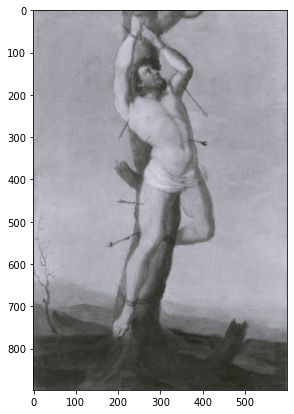

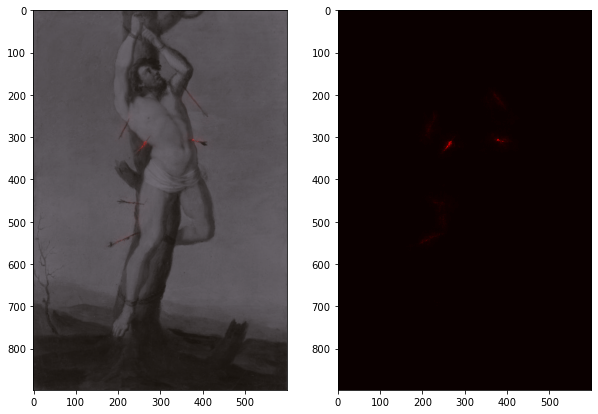

In [29]:
from PIL import Image
img3 = Image.open(img_path).convert('RGB')
saliency(img3, model)